# Lab 3:  Decision Tree, Bagging, and Random Forests


Decision trees, bagging, and random forecasts can be used for either regression or classification tasks. Decision trees are a powerful tool; however, are very prone to overfitting the training dataset and therefore often fail to generalize well to test data sets.  To overcome Decisions Trees tendancy to overfit, one can aggregate the results from many decision trees with an [enesemble approach](http://scikit-learn.org/stable/modules/ensemble.html). In this lesson we will focus on Random Forests, which prevent overfitting by only allowing a given decision tree to optimize for a random subset of the data for every tree, and a random subset of the input features at every split (Don't worry, much more to come :) ). 


<img src="../images/DecisionTreeExample.png" alt="Drawing" style="width: 500px;height=500"/>

A quick refresher on Bagging:
- Grow multiple decisions trees from random subsets of the data
- All features are considered at every split in the decision tree
- The result is the average prediction of all trees

A quick refresher on the Random Forest theory:
- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- **At every split, a new random subset of features is chosen**
- This leads to "decorrelated" trees which leads to a large increase in performance!

Here's a look ahead at what we'll be doing in this notebook:


1. [Load data and packages](#loaddata)   
  1.1 Load python packages  
  1.2 Set jupyter notebook preferences  
  1.3 Load Data
    

2. [Build Decision Tree](#decissiontree)

3. [Discuss requirements of Decision Trees](#assumptions)

4. [Decision Tree Interpretation and Validation](#interpretation1)

5. [Build Random Forest](#randomforest)

6. [Random Forest Interpretation and Validation](#randomforest)

After we run our decision trees, we will compare our new output to our output from the linear regressions we ran in the previous notebook. We will use the same features and will be predicting the same outcome feature loan_amount.

In this notebook, we will be looking at how we can predict the loan amount using decision trees, bagged decisions trees and the random forest algorithm. However, it is worth mentioning that these methods can also be used to classify data, for example some interesting classification questions we could investigate are:
- Can we classify which loans expired and which one got funded?
- Is a loan posted by a male or female?

Feel free to investigate these on your own time! Here is a very simple example of how the RandomForestClassifier works: https://bicorner.com/2015/10/26/random-forest-using-ipython/

## 1. Import packages
<a id='loaddata'></a>

In [158]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from ggplot import *
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import graphviz 
from sklearn import tree

In [159]:
# Load data to pandas DataFrame
data_path = '../../data/'
df = pd.read_csv(data_path+'df_abridged.csv', low_memory=False)

In [160]:
# TODO: Remove this part and incorporate it into feature engineering section.
# potentially the feature engineering section should show how to do one hot encoding and this module
# will reference one hot encoding and remove any cols that are strings to highligh that sklearn's implementation
# cannot handle strings.
df['female'] = df['gender'].apply(lambda x: x=='Female')
df = df.dropna()
cols = df[['loan_amount', 
           'partner_delinquency_rate',
            'posted_year',
           'posted_month',
           'female',
           'num_tags',
           'parent',
           'tag_#Woman Owned Biz',
           'age_int',
           'tag_#Repeat Borrower',
           'children_int',
           'borrower_count',
          'more_one_partner_country',
          'days_to_fund',
          'terms.repayment_term',
           'tag_#Schooling',
           'married',
           'pct_female',
           'exploratory_partner',
           'partner_dollar_amount',
           'top_partner_id',
           'num_partner_countries',
           'days_to_fund',
       'hours_to_fund'
          ]]

Just like last module, we are going to build regressors to predict the loan amount; however, instead of using one of the features, we are going to initially build a tree that considers all of the features in the database. 

In [161]:
y = df['loan_amount']
# drop returns a copy of the DataFrame with the specified columns removed.  
X = cols.drop('loan_amount', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step by Step approach to modeling:

For the following methods used, there is some standard steps used to implement the algorithms. A simple overvew of these steps are:
- **Step 1: Initiate the algorithm** This is where we define the parameters (& hyperparameters of the algorithm) of the algorithm. For example, this is where we would define the maximum depth, the minimum samples in a leaf etc. To learn more about the parameters for each algorithm, either check the module documentation on the internet or run a cell with the algorithm name followed by ? as we did at the beginning of this notebook for the RandomForestRegressor. These resources will also tell you the default values used for each parameter. 
- **Step 2: Train the algorithm** This is where we train the algorithm by fitting it to the X_train and y_train datasets. 
- **Step 3: Evaluating the algorithm** This is where we evaluate the predictive power of the algorithm by comparing the predictive loan amount values to the true values. We can do this for the training and testing dataset.

Let's start with **loan amount** and see if we can predict how much is requested to be funded using the decision trees and ensemble methods! 

### Decision Tree
Before we initialize our model, let's first learn about the input parameters for sklearn's implementation of a Decision Tree Regressor.  Feel free to look at the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.get_params), or simply put a question mark before a call to the class.  Prepending a ? to any method, variable, or class will display that method's defined docstring (way to go ipthon!)

In [162]:
?DecisionTreeRegressor

In [163]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters,print_oob_score=False):
    '''
    Purpose: 
        - train a regressor on training data
        - score data on training and test data
        - return trained model
    '''
    # Step 1: Initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)
    # Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    # Step 3: Calculating the score of the predictive power on the training and testing dataset.
    training_score = regressor.score(X_train, y_train)
    testing_score = regressor.score(X_test, y_test)
    print("Train score: " + str(training_score))
    print("Test score: " + str(testing_score))
    if print_oob_score:
        print("OOB score: " + str(regressor.oob_score_))
        
    return regressor
?train_score_regressor

With all tree algorithms the major challenge is using the parameters to balance the bias vs variance tradeoff.  Before we get into exploring the parameters, let's see how the model preforms while using the default values.

In [164]:
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {})

Train score: 1.0
Test score: 0.324098849052


While the Decision Tree managed to get a perfect r2 scored on the training data, it managed an abysmal .34 on the test data.  This is a clear indication that the model has overfit the data.  Given that by default sklearn's implementation of a DecisionTreeRegressor does not put any restrictions on the depth of the tree, the number of samples per leaf, the number of samples per leaf, etc.  As a result, the Decision Tree will find signal in any and all noise of the training data set, which causes the model to perform poorly on the test data.  When a model overfits to a training data set, we say it has high variance.  Since an unconstrained decision tree will almost perfectly model any training data, it will vary tremendously depending on the training data that is provided.

To reduce the variance, let's now try to constrain the model using some of the provided parameters.

In [165]:
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"max_depth":3})

Train score: 0.520733609128
Test score: 0.414153813957


Although the training r2 score plummeted down to .52, the test r2 score increased to .41, and since the goal is develop a model that accurately predict data we have never seen, that is the data we care about!

Now that we have increased preformance, let's take a look at what the Decision Tree looks like.

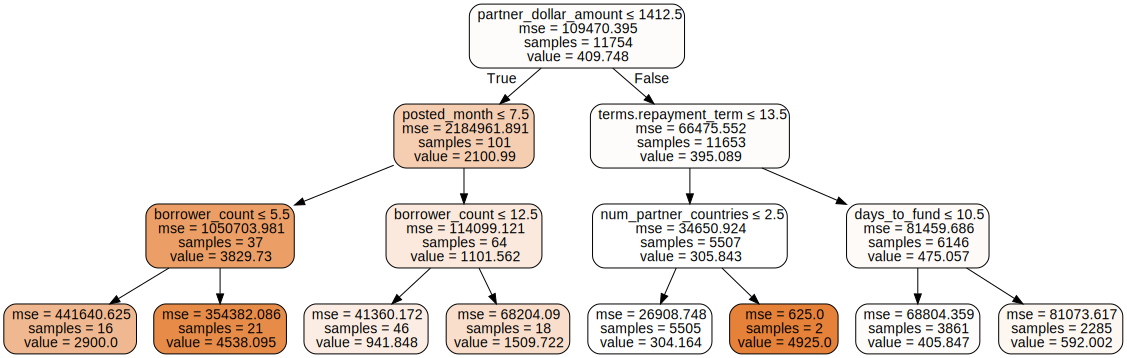

In [166]:
dot_data = tree.export_graphviz(trained_regressor, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=y_train.values,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

As you can see, even a DecisionTreeRegressor with a max depth of 3 is rather complicated.  To develop your intuition for the various input parameters, I recommend manually adjusting them up and down to see the impacts.

If you were to tune the parameters manually and see how it impacts the training and test data sets that we created above, you would slowly tune towards a higher score on the test data set; however, you would most likely be overfitting to the test data set and the model would not generalize well to a secondary test data set.  To avoid this, it is recommended that you use [k-fold](https://www.analyticsvidhya.com/blog/2015/11/improve-model-performance-cross-validation-in-python-r/) validation.

In addition to k-fold validation, we wil use sklearn's GridSearchCV, which allows us using k-fold validation to assess every permuation of possible values for the parameters that we provide.

**Note** since we are training one regressor one time for each possible permutation of specified parameter values, this next cell will take some time to run.  That is why you need to gain an intuition for which values to test!

In [111]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':[2,6,8,10,14], 
              'max_features': ['auto','sqrt',None],
              'min_impurity_decrease': [.1,.01, 0.0],
              'min_samples_split': [10, 50, 100, 2]}
decision_regressor= DecisionTreeRegressor()
regressor = GridSearchCV(decision_regressor, parameters)
regressor.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 8, 10, 14], 'max_features': ['auto', 'sqrt', None], 'min_impurity_decrease': [0.1, 0.01, 0.0], 'min_samples_split': [10, 50, 100, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [112]:
# Now that we have finished up training lets print out what GridSearchCV found to be the best parameters 
regressor.best_estimator_.get_params()

{'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.01,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

Now lets see what happens when we train a DecisionTreeRegressor using these parameters on our original training and test data.

In [130]:
trained_regressor = train_score_regressor(sklearn_regressor = DecisionTreeRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = regressor.best_estimator_.get_params())

Train score: 0.690311428983
Test score: 0.564427136188


Performance on the test data has almost doubled!

The R^2 number above is pretty telling but it is always nice to visualise how these look in a scattor plot. This allows us to visualise the variation between the predicted loan amount and the true loan amount values. 

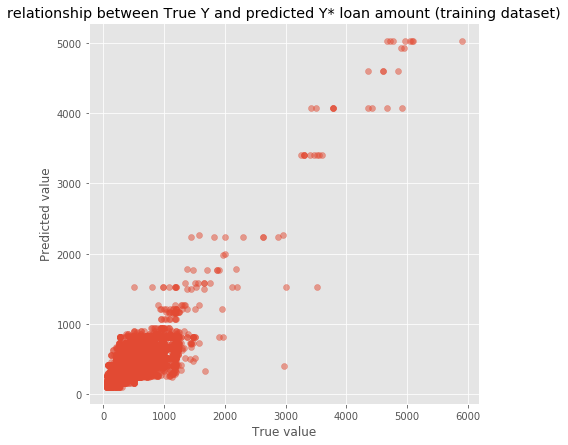

In [167]:
# plotting a graph of the true values vs the predicted values for the training and test datasets
def plot_y_yhat_scatter(y_actual,y_predicted,train_test):
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(y_actual, y_predicted, alpha=0.5)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title("relationship between True Y and predicted Y* loan amount ({0} dataset)".format(train_test))
    plt.show()
    
plot_y_yhat_scatter(y_train, decision_regressor.predict(X_train),train_test = "training")


## Bagging

##### TODO: Beef up introduciton to Bagging - Jack

As we just saw, Decision Trees naturally overfit to the data.  One approach to addressing this is by parameter tuning for an individual tree; however, better perforamnce is generally achieved when an ensemble approach such as baggin is used.

A bagging regressor builds some specified number of trees and trains each tree with a random subset of the data and then averages the forecast of each individual tree. 

This is an **Ensemble approach** where we use the results of several random analyses to find an average response. For each tree, there will be a sample of data which was not used to train the algorithm. This means that we can also measure the **out-of-bag** score ( or oob_score). This score calculates the error rate of the predictions on the sample not used while training an individual tree. (Remember a random ~2/3 of data are used to train a given tree).

In [168]:
# Step 1: Initiating the bagging regressor algorithm
trained_regressor = train_score_regressor(sklearn_regressor = BaggingRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"oob_score":True},print_oob_score=True)

Train score: 0.937021136541
Test score: 0.588517831278
OOB score: 0.566909547097


/Users/j/virtualenvs/delta/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


The above results are very encouraging. Prior to any parameter tuning, the model is already preforming better on the test data set.

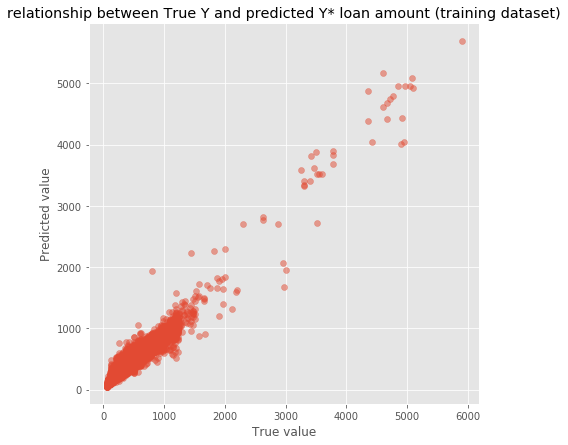

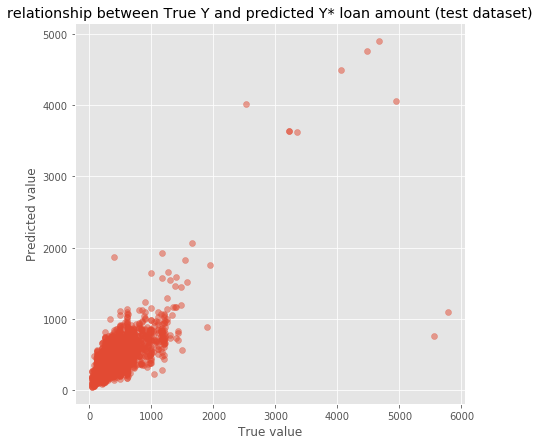

In [169]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test = "training")
# plotting a grpah of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test = "test")

##### TODO: Consider moving to another section - Jack
When comparing the different regression models, we will be looking at three main outputs:
- Train score = R^2 between the predicted and true values for the training dataset
- Test score = R^2 between the predicted and true values for the test dataset
- Oob_score = the error rate of predicted values for data not used whilst training an individual tree

### Changing some model parameters

The default number of trees used in the bagging regressor is 10. This means that the algorithms splits the dataset into 10 different tress, trains each one individually, predicts the result from each one individually and then averages the result. 

Let's see how performance changes when we increase the number of trees from 10 to 100.

In [177]:
trained_regressor = train_score_regressor(sklearn_regressor = BaggingRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"oob_score":True, "n_estimators": 100},
                                          print_oob_score=True)

Train score: 0.956688086511
Test score: 0.599801303312
OOB score: 0.683232260295


Here we see an improvement in all score and in particular the oob_score. This is telling us that splitting the dataset into more tree leads to a more accurate average predicton of the loan_amount. 

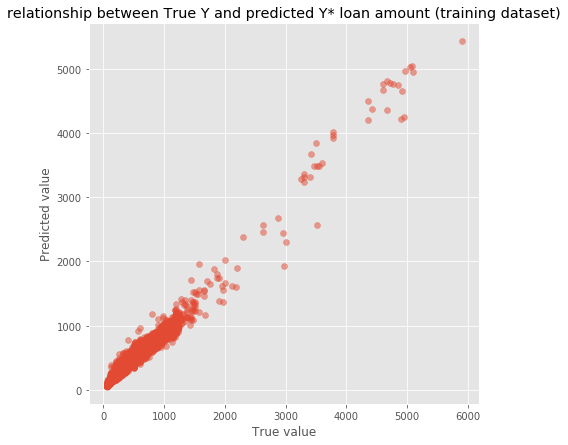

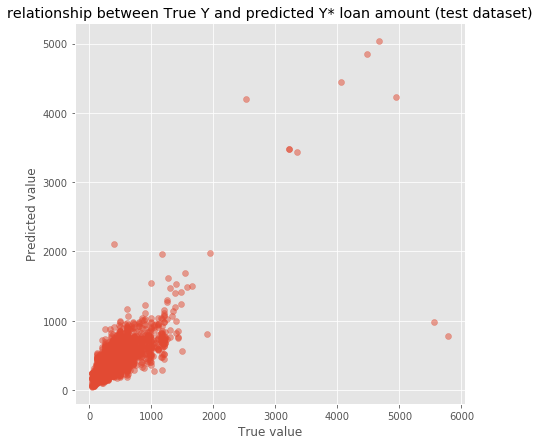

In [171]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test = "training")
# plotting a grpah of the true values vs the predicted values for the training and test datasets
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test = "test")

## Random Forest

##### TODO: Add more to introduction and drive home difference between RF and bagging - Jack

We still observe a large discrepancy between the training data and the test data.  This is largely because the decision trees are largely correlated, meaning that ubsets of the same data are probably going to split on the same features and result in very similar predictions.

To de-correlate the trees, we can use a Random Forest Regressor, which only considers a random subsample of the features at each split.

In [181]:
trained_regressor = train_score_regressor(sklearn_regressor = RandomForestRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"oob_score":True, "n_estimators": 300},
                                          print_oob_score=True)

Train score: 0.957734141851
Test score: 0.607648548924
OOB score: 0.68783496965


We can see that the random forest algorithm has improved the generalization performance relative to the bagging regressor. This indicates that the features we are using are already highly uncorrelated.

## Further Hyperparameter Tuning

Since we are relying on OOB score, we do not in fact need to have a separate test set. We can use our full dataset for training with a small subset held to the side for each model to compute the OOB score. 

We also increase the number of estimators in our model to 400 and set the min_samples_leaft to 20 to improve upon overfitting.

In [173]:
trained_regressor = train_score_regressor(sklearn_regressor = RandomForestRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"oob_score":True, "n_estimators": 400,
                                                             "min_samples_leaf": 20},
                                          print_oob_score=True)


Train score: 0.673481457953
Test score: 0.508287109651
OOB score: 0.620979736036


Recall that the difference between the Bagging Regressor and the RandomForest is that in the RandomForest, at each split, a random subset of features is considered. The reducing the chance of correlation between the different trees. 

Now, let's try to figure out which features are driving our model's predictions.  Although we do not have the coefficients provided by a linear regression, we can analyze what percentage of the overall variance was explained by a given feature.

#### TODO: 1. Plot feature importances 2. Show plot with y axis being performance and x being n_estimators- Jack

In [469]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, rf_trainX.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature borrower_count (0.318045)
2. feature posted_year (0.189317)
3. feature terms_repayment_term (0.125958)
4. feature posted_month (0.103770)
5. feature more_one_partner_country (0.058790)
6. feature married (0.045853)
7. feature top_partners_One_Acre_Fund (0.030658)
8. feature partner_delinquency_rate (0.028189)
9. feature sector_Agriculture (0.011180)
10. feature top_partners_Yehu_Microfinance_Trust (0.009866)
11. feature pct_female (0.007647)
12. feature sector_Education (0.006858)
13. feature parent (0.006806)
14. feature tag_Repeat_Borrower (0.006435)
15. feature top_partners_VisionFund_Kenya (0.005788)
16. feature top_partners_Other (0.005657)
17. feature children_int (0.005538)
18. feature age_int (0.005265)
19. feature top_partners_SMEP_Microfinance_Bank (0.005045)
20. feature top_partners_Juhudi_Kilimo (0.004051)
21. feature tag_Woman_Owned_Biz (0.003347)
22. feature sector_Retail (0.003096)
23. feature top_partners_Milango_Financial_Services (0.002805)

What is interesting here is that there is not a very clear relationship between any single feature and the loan_amount. However the aggregat these features together into either the bagged regressor or the random forest algorithm leads to very effective predictions (R^2 ~ 0.74). This is a testament to the predictive power of decisions trees and ensemble methods!

Let's try taking the top 20 features and observe it's impact on performance

In [470]:
relevant_cols = [rf_trainX.columns[indices[f]] for f in range(20)]
X_train2 = rf_trainX[relevant_cols]

In [471]:
# Step 1: Initiating the bagging regressor algorithm
rf_regressor = RandomForestRegressor(n_estimators=400, random_state=42, min_samples_leaf=20,oob_score=True)
# Step 2: Training the bagging regressor algorithm
rf_regressor.fit(X_train2,rf_trainY)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
print_scores_full(rf_regressor, X_train2,rf_trainY , oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

Train score: 0.750354152481
OOB score: 0.721037056895


The scores haven't changed significantly which means that we can continue just using the top 20 features. This means the algorithms is much faster and gives us a clearer idea of which features affect the loan amount

In [472]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, X_train2.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature borrower_count (0.320873)
2. feature posted_year (0.191886)
3. feature terms_repayment_term (0.130257)
4. feature posted_month (0.105737)
5. feature more_one_partner_country (0.059595)
6. feature married (0.046283)
7. feature partner_delinquency_rate (0.031012)
8. feature top_partners_One_Acre_Fund (0.030844)
9. feature sector_Agriculture (0.011631)
10. feature top_partners_Yehu_Microfinance_Trust (0.010544)
11. feature pct_female (0.007960)
12. feature sector_Education (0.007060)
13. feature parent (0.007056)
14. feature tag_Repeat_Borrower (0.006592)
15. feature age_int (0.006199)
16. feature children_int (0.006145)
17. feature top_partners_VisionFund_Kenya (0.005884)
18. feature top_partners_SMEP_Microfinance_Bank (0.005069)
19. feature top_partners_Other (0.005030)
20. feature top_partners_Juhudi_Kilimo (0.004345)


Before we move onto homework, remember to output your final dataframe so you don't have to rerun it.

In [473]:
df.to_csv(data_path+'df_module_3-2.csv')

## Predicting Days to Fund

Repeat the BaggingRegressor and the RandomForestRegressor method with a new target feature: days_to_fund. Determine the monst important features and discuss which features are intuitive or a surprise and why. 


In [147]:
# adding the loan_amount feature back into the rf_trainArr dataset
rf_trainArr['loan_amount'] = rf_trainRes
# The new target feature result is the days_to_fund so pull that out and drop it from the training array
rf_trainRes = rf_trainArr['days_to_fund']
rf_trainArr = rf_trainArr.drop('days_to_fund', axis=1)

In [ ]:
# Create X_train, y_train, X_test and y_test where the y value is the days_to_fund feature. 
# Try using test_train_split function imported from sklearn

Remember the three basic steps:
- step 1: Initiate the algorithm
- step 2: Fit the algorithm to the training data
- step 3: Evaluate the algorithm performance

In [ ]:
# Use the BaggingRegressor method to predict the days_to_fund

In [ ]:
# Use the RandomForest Regressor method to predict the days_to_fund

In [ ]:
# Find the most important features

## Advanced Homework (optional)

The sklearn RandomForest library also has a classifier method, which rather than predicting a continuous numerical value such as loan amount or days to fund, it attempted to classify data on existing labels, eg: male or female. 

We imported this method at the beginning and you can read more about it here using the following cell or by going the sklearn [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) webpage.

In [148]:
RandomForestClassifier?

Using this module and the original feature gender, see how well we can classify loans by the gender. The procedure for training and testing data is practically the same as the RandomForestRegressor and the score is the mean accuracy of the predictions rather than the R^2 of the regression. 

## Advanced Material: Optimising the algorithm

Up to this point, we have been largely been using the default values for all of the hyper-parameters.  To increase perfromance we should try adjusting these parameters.  Sklearn's GridSearchCV uses cross-validation to assess the performance of each possible permutation of the hyper-parameters that you specify.

In [140]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100, 300, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [None, 5, 10]
             }
gridrf = RandomForestRegressor()
grid_rf = GridSearchCV(gridrf, parameters)

In [141]:
grid_rf.fit(X_train2, y_train)

KeyboardInterrupt: 

To find out which set of parameters performed best, we can use the .best\_pramas\_ method

In [ ]:
grid_rf.best_params_

Next, let's check out the variation in performance.

In [ ]:
means = grid_rf.cv_results_['mean_test_score']
stds = grid_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))